This notebook implements Monte Carlo control with exploring starts policy for the Blackjack environment, described in Chapter 5 of Sutton's book. 

In particular, it replicated this optimal control policy: 
![mc-control.png](../images/mc-control.png)

In [7]:
import platform
print(platform.python_version()) # >=3.7.1rc1 required for dataclass

from dataclasses import dataclass
from enum import Enum

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

3.7.1rc1


In [4]:
import random
class Deck:
    def __init__(self, seed:int=42):
        self.seed = seed
        random.seed(self.seed)
        
        self._cards = list(range(1, 10)) + [10] * 4
    
    def draw(self) -> int:
        '''
        with probability 1/13, it returns 1 to 9, where 1 is Ace
        with probability 4/13, it returns 10
        this is where I wish I can use sealed traits to represent cards, instead of int
        '''
        return random.choice(self._cards)

In [3]:
# test the deck out
deck = Deck()
assert(len(deck._cards) == 13)

distribution = {}
for i in range(0, int(1e4)):
    card = deck.draw()
    distribution[card] = distribution.get(card, 0) + 1

for card, count in distribution.items():
    print(card, count) # 10 should have roughly 4x more than others

10 3179
2 780
1 714
5 752
4 723
3 782
9 775
7 743
8 791
6 761


In [4]:
# helper function to get sum of cards, considering whether to use ace as 11 or not
def sum_cards(cards) -> int:
    if 1 in cards:
        if sum(cards) + 10 <= 21:
            return sum(cards) + 10
        else:
            return sum(cards)
    else:
        return sum(cards)
    
# test
assert(sum_cards([2,3]) == 5)
assert(sum_cards([1,5]) == 16)
assert(sum_cards([1,5,10]) == 16)
assert(sum_cards([1,1]) == 12)
assert(sum_cards([1,1,1]) == 13)

In [8]:
# MDP classes
@dataclass
class State:
    current_sum: int
    showing_card_from_dealer: int
    has_usable_ace: bool
        
    def __str__(self):
        return "%d-%d-%s" % (self.current_sum, self.showing_card_from_dealer, self.has_usable_ace)
        
class Action(Enum):
    HIT = 1
    STICK = 2

In [9]:
from abc import ABC, abstractmethod

class Policy(ABC):
    def __init__(self, debug=False):
        self._debug = debug
        
    @abstractmethod
    def pi(self, state:State) -> Action:
        ...

In [11]:
class Policy1(Policy):
    '''
    stick if sum is 20 or 21, hit otherwise
    @param:
    is_first: whether this is the first action in one episode, used for exploring starts
    ''' 
    def pi(self, state:State, is_first:bool=False) -> Action:
        if self._debug:
            print("[policy debug] received state", state)
        if state.current_sum >= 20:
            return Action.STICK
        else:
            return Action.HIT

In [8]:
class BlackjackEnv:
    def __init__(self, seed:int = 42, debug = False):
        self._deck = Deck(seed)
        self._debug = debug
        self._dealer_cards = []
        self._player_cards = []
        self._state = None
        
    def reset(self) -> (State, int, bool):
        '''
        The game begins with two cards dealt to both dealer and player. 
        Dealer's first card is faced up and the other faced down. 
        If the player has 21 immediately (an ace and a 10-card), it is called a natural. 
        He then wins unless the dealer also has a natural, in which case the game is a draw.
        
        @returns (next state, reward, is_terminated)
        all rewards are terminal:
        1 if player wins
        -1 if player loses
        0 if it's a draw
        '''
        self._dealer_cards = []
        self._player_cards = []
        self._state = None
        
        player_cards = [self._deck.draw(), self._deck.draw()]
        dealer_cards = [self._deck.draw(), self._deck.draw()]
        
        self._player_cards = player_cards
        self._dealer_cards = dealer_cards
        
        if self._debug:
            print("[env debug] player's first two cards: ", player_cards)
            print("[env debug] dealer's first two cards: ", dealer_cards)
        
        state = State(
            sum_cards(player_cards),
            dealer_cards[0],
            1 in player_cards and sum(player_cards) + 10 <= 21
        )
        self._state = state
        
        if set(player_cards) == set([1,10]):
            if set(dealer_cards) == set([1,10]): # draw
                return (state, 0, True)
            else: # win
                return (state, 1, True)
        else: # game continues
            return (state, 0, False)
    
    def step(self, action:Action) -> (State, int, bool):
        '''
        @returns
        same as reset(self)
        '''
        if action == Action.STICK:
            # dealer sticks when sum >= 17, and hit otherwise
            # dealer loses if goes bust, else compare final sum
            dealer_sum = sum_cards(self._dealer_cards)
            while dealer_sum < 17: 
                card = self._deck.draw()
                if self._debug:
                    print("[env debug] draw card for dealer", card)
                self._dealer_cards.append(card)
                dealer_sum = sum_cards(self._dealer_cards)
            
            if dealer_sum > 21: # dealer goes bust
                return (self._state, 1, True)

            # compare final sum
            if self._state.current_sum > dealer_sum:
                return (self._state, 1, True)
            elif self._state.current_sum == dealer_sum:
                return (self._state, 0, True)
            else:
                return (self._state, -1, True)
        
        else:
            # draw one more card for player
            card = self._deck.draw()
            self._player_cards.append(card)
            if self._debug:
                print("[env debug] draw card for player", card, self._player_cards)
            player_sum = sum_cards(self._player_cards)
            state = State(
                player_sum,
                self._state.showing_card_from_dealer, 
                1 in self._player_cards and sum(self._player_cards) + 10 <= 21
            )
            self._state = state
            
            # check if player has busted or not
            if player_sum > 21:
                return (state, -1, True)
            else:
                return (state, 0, False)
            
    def info(self):
        print("[env info] player cards:", self._player_cards)
        print("[env info] dealer cards:", self._dealer_cards)

In [9]:
def simulate(env, policy):
    '''
    simulate one episode
    @return: (episode, reward)
    where episode is a list of [state, action, state, action, ..., final_state]
    '''
    observation, reward, done = env.reset()
    episode = [observation]
    if done:
        return (episode, reward)
    else:
        action = policy.pi(observation, is_first=True)
        observation, reward, done = env.step(action)
        episode += [action, observation]

        while not done:
            action = policy.pi(observation)
            observation, reward, done = env.step(action)
            episode += [action, observation]

        return (episode, reward)

In [10]:
# test blackjack env
env = BlackjackEnv(seed=42, debug=True)
policy = Policy1(debug=True)

episode, reward = simulate(env, policy)
for i in episode:
    print("[episode]", i)
print(reward)
env.info()

[env debug] player's first two cards:  [10, 2]
[env debug] dealer's first two cards:  [1, 10]
[policy debug] received state 12-1-False
[env debug] draw card for player 5 [10, 2, 5]
[policy debug] received state 17-1-False
[env debug] draw card for player 4 [10, 2, 5, 4]
[policy debug] received state 21-1-False
[episode] 12-1-False
[episode] Action.HIT
[episode] 17-1-False
[episode] Action.HIT
[episode] 21-1-False
[episode] Action.STICK
[episode] 21-1-False
0
[env info] player cards: [10, 2, 5, 4]
[env info] dealer cards: [1, 10]


In [11]:
# visualize policy graph w.r.t total 200 possible states, see Figure 5.2
def visualize(policy:Policy):
    '''
    visualise policy; above the cutoff line is STICK region, below is HIT
    '''    
    def stick_cutoff(has_usable_ace:bool):
        # get the separation between HIT and STICK 
        result = []
        for showing_card_from_dealer in range(1, 11):
            for player_sum in range(12, 22):
                state = State(player_sum, showing_card_from_dealer, has_usable_ace)
                action = policy.pi(state)
                if action == Action.STICK:
                    result.append(player_sum)
                    break
        return result
                        
    ys_with_ace = stick_cutoff(True)
    ys_without_ace = stick_cutoff(False)
                
    plt.figure(1)
    plt.subplots_adjust(wspace = 0.5)
    
    plt.subplot(121)
    plt.title("with usable ace")
    plt.xlabel("dealer showing")
    plt.ylabel("player sum")
    plt.xticks(np.arange(1,11,1))
    plt.yticks(np.arange(12,22,1))
    plt.plot(list(range(1,11)),ys_with_ace)
    
    plt.subplot(122)
    plt.title("without usable ace")
    plt.xlabel("dealer showing")
    plt.ylabel("player sum")
    plt.xticks(np.arange(1,11,1))
    plt.yticks(np.arange(12,22,1))
    plt.plot(list(range(1,11)),ys_without_ace)

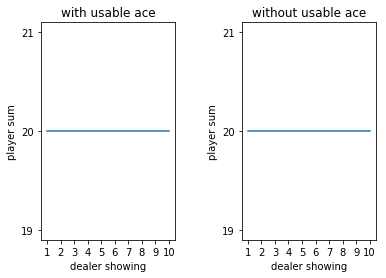

In [12]:
visualize(Policy1())

In [14]:
class MCPolicy(Policy):
    '''
    first visit MC control policy
    '''
    def __init__(self, seed=42, debug=False):
        self.initialise_q()
        self.seed = seed
        super().__init__(debug)
    
    def initialise_q(self):
        self.q = {}
        for player_sum in range(12, 22):
            for showing_card_from_dealer in range(1, 11):
                for has_usable_ace in [True, False]:
                    state = State(player_sum, showing_card_from_dealer, has_usable_ace)
                    self.q[str(state)] = {
                        Action.HIT: {"count":0, "q":0.0},
                        Action.STICK: {"count":0, "q":0.0}
                    }
    
    def pi(self, state:State, is_first:bool=False) -> Action:
        if self._debug:
            print("[policy debug] received state", state)
        if state.current_sum <= 11:
            return Action.HIT
        else:
            if is_first: # exploring start
                if self._debug:
                    print("[policy debug] exploring starts")
                return random.choice([Action.HIT, Action.STICK])
            else:
                q = self.q[str(state)]
                if q[Action.HIT]['q'] > q[Action.STICK]['q']:
                    return Action.HIT
                elif q[Action.HIT]['q'] < q[Action.STICK]['q']:
                    return Action.STICK
                else:
                    return random.choice([Action.HIT, Action.STICK])
        
    def update_q(self, episode, reward):
        '''
        episode is [state, action, state, action, ..., final_state]
        '''
        seen = set()
        for (state, action) in [(episode[i], episode[i+1]) for i in range(0, len(episode)-1, 2)]:
            key = "%r-%s" % (state, action)
            if key not in seen:
                seen.add(key)
                # incrementally update average
                if str(state) in self.q.keys():
                    # this if is necessary because we may receive state where player_sum <= 11
                    # in this case we always STICK, so it's not an interesting space
                    new_count = self.q[str(state)][action]['count'] + 1
                    current_average = self.q[str(state)][action]['q']
                    new_average = current_average + 1./new_count*(reward-current_average) 
                    self.q[str(state)][action]['count'] = new_count
                    self.q[str(state)][action]['q'] = new_average
    
    def show(self):
        '''
        output q values where count > 0
        '''
        for state in self.q.keys():
            if self.q[state][Action.HIT]['count'] > 0 or self.q[state][Action.STICK]['count'] > 0:
                print("[policy debug] updated q value for state ", state, self.q[state])

In [14]:
debug = False
seed = 42
policy = MCPolicy(seed=seed, debug=debug)
env = BlackjackEnv(seed=seed+1, debug=debug)

for i in range(int(1e7)):
    if i % 1e6 == 0:
        print("iteration ", i)
#     print("===== new simulation")
    episode,reward = simulate(env, policy)
#     print("[simulate debug] iteration:", i, "reward:", reward, "final state:", episode[-1], "dealer cards:", env._dealer_cards)
#     for state in episode:
#         print("[simulate debug]", state)
    policy.update_q(episode, reward)

# policy.show()

iteration  0
iteration  1000000
iteration  2000000
iteration  3000000
iteration  4000000
iteration  5000000
iteration  6000000
iteration  7000000
iteration  8000000
iteration  9000000


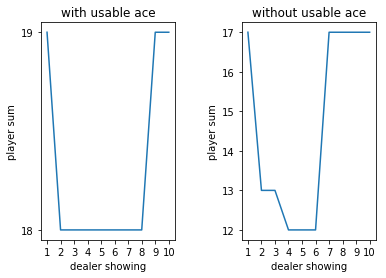

In [15]:
visualize(policy)

In [ ]:
# for debug purpose
for s in range(12,22):
    state = State(s, 4, True)
    print(s, policy.pi(state), policy.q[str(state)])